In [1]:
import altair as alt
import numpy as np
import pandas as pd
import pandas_gbq
import os.path
import seaborn as sns
import category_encoders as ce
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_columns = None

In [4]:
# Speaker order date starts from 2022-03
product = "swipe" # Comment out the app data (read and merge) for Speaker

In [5]:
# push_merchants_in_application = pd.read_csv(f"{product}_push_merchants_in_application.csv")
tot_push_merchants = pd.read_csv(f'{product}_total_push_merchants.csv')
tot_app_merchants = pd.read_csv(f'{product}_total_application_merchants.csv')
vint = pd.read_csv(f'{product}_vin.csv')

In [6]:
vin_dic = vint.set_index('merchant_id')['vintage'].to_dict()

In [7]:
print(f"There are a total of {tot_push_merchants.shape[0]} merchants in Push (lmp)")

There are a total of 432289 merchants in Push (lmp)


In [8]:
# print(f"There are {push_merchants_in_application.shape[0]} merchants which moved to Application within 7 days of Push (lmp)")

In [9]:
print(f"There are a total of {tot_app_merchants.shape[0]} merchants in Application")

There are a total of 289407 merchants in Application


In [10]:
pdt_final = pd.DataFrame()
pdt_final['merchant_id'] = list(set(list(tot_app_merchants['merchant_id']) + list(tot_push_merchants['merchant_id'])))

In [11]:
print(f"There are a total of {pdt_final.shape[0]} distinct merchants in the union of Application and push tables")

There are a total of 538119 distinct merchants in the union of Application and push tables


In [12]:
# c1 = pdt_final['merchant_id'].isin(push_merchants_in_application['merchant_id'])
c2 = (pdt_final['merchant_id'].isin(tot_app_merchants['merchant_id'])) & (~pdt_final['merchant_id'].isin(tot_push_merchants['merchant_id']))
c3 = pdt_final['merchant_id'].isin(tot_app_merchants['merchant_id'])

# c = c1 | c2
pdt_final['target'] = np.where(c3, 1, 0)

In [13]:
# print(f"There are a total of {sum(c2)} merchants that were never in the Push but in the Application")

In [14]:
pdt_final['target'].value_counts()

1    289407
0    248712
Name: target, dtype: int64

In [15]:
trxn_pdt = pd.read_csv(f"trxn_{product}.csv")
merchant_data_mart = pd.read_csv(f"{product}_merchant_data_mart.csv",low_memory=False)
app_pdt = pd.read_csv(f'app_{product}.csv') # Comment this out for speaker

In [16]:
pdt_flag = f'{product}_flag'
pdt_order_date = f'{product}_order_date'

In [17]:
rel_cols = ['merchant_id', 'actual_merchant_type','area_name','zone_name','region_name','territory_name',\
                            'business_category','merchant_acquisition_channel',\
                            pdt_order_date,'merchant_created_at','geohash6','geohash3', 'geohash4']
if product in ['loan','fp']: 
    rel_cols = ['merchant_id', 'actual_merchant_type','area_name','zone_name','region_name','territory_name',\
                            'business_category','merchant_acquisition_channel','merchant_created_at','geohash6','geohash3', 'geohash4']



pdt = merchant_data_mart[rel_cols]

In [18]:
device = """
SELECT * FROM `bharatpe-analytics-prod.bharatpe_ml_data.merchant_device_info`
"""
device = pandas_gbq.read_gbq(device)

Downloading: 100%|██████████| 9236615/9236615 [04:34<00:00, 33690.23rows/s]


In [19]:
device = device[device['merchant_id'].isin(pdt_final['merchant_id'])]

In [20]:
pdt_final = pdt_final.merge(device[['merchant_id','manufacturer']], how = 'left', left_on = "merchant_id", right_on = "merchant_id")

In [21]:
del(device)

In [22]:
pdt_final['manufacturer'].fillna('Other', inplace = True)
# pdt_final['version'].fillna('Other', inplace = True)

In [23]:
pdt_final = pdt_final.merge(pdt, how = 'left', left_on = "merchant_id", right_on = "merchant_id")

In [24]:
pdt_final = pdt_final.merge(trxn_pdt, how = 'left', left_on = "merchant_id", right_on = "merchant_id")

In [25]:
# Comment this for speaker
pdt_final = pdt_final.merge(app_pdt, how = 'left', left_on = "merchant_id", right_on = "merchant_id")

In [26]:
c1 = pdt_final['w1_txn_count'] - pdt_final['w2_txn_count']
c2 = pdt_final['w2_txn_count'] - pdt_final['w3_txn_count']
pdt_final['trend'] = np.where((c1>0) & (c2>0), "up",np.where((c1<0) & (c2<0),"down","flat"))

In [27]:
pdt_final['vintage'] = pdt_final['merchant_id'].map(vin_dic)

In [28]:
pdt_final['manufacturer'] = pdt_final['manufacturer'].str.lower()
pdt_final['manufacturer'] = pdt_final['manufacturer'].replace({'tecno mobile limited': 'tecno', 'infinix mobility limited': 'infinix', 'hmd global': 'hmd'\
                                   , 'itel mobile limited': 'itel'})

major_brands = list(pdt_final['manufacturer'].str.lower().value_counts()[:20].index)

pdt_final['manufacturer'] = np.where(pdt_final['manufacturer'].isin(major_brands),pdt_final['manufacturer'], 'other')
# pdt_final['version'] = pdt_final['version'].apply(lambda x :"new" if x in ('11','12') else 'old')

In [29]:
geo = 'geohash4'

In [30]:
loc_hash_density = pdt_final.groupby(geo).apply(lambda x:x['merchant_id'].nunique()).sort_values(ascending = False).to_dict()
pdt_final['loc_hash_density'] = pdt_final[geo].map(loc_hash_density)

In [31]:
loc_hash_atv = pdt_final.groupby(geo).apply(lambda x:x['total_tpv'].sum()/ len(x)).sort_values(ascending = False).to_dict()
pdt_final['loc_hash_atv'] = pdt_final[geo].map(loc_hash_atv)

In [32]:
loc_hash_tpv = pdt_final.groupby(geo).apply(lambda x:x['total_tpv'].sum()).sort_values(ascending = False).to_dict()
pdt_final['loc_hash_tpv'] = pdt_final[geo].map(loc_hash_tpv)

In [33]:
##### Model

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import plot_confusion_matrix

In [35]:
# sum(pdt_final['txn_count_90_days'].isna())

In [36]:
pdt_final = pdt_final[~pdt_final['txn_count_90_days'].isna()]

In [37]:
pdt_final['target'].value_counts()

1    288669
0    237650
Name: target, dtype: int64

In [38]:
if product == 'fp':
    pdt_final = pd.concat([pdt_final[pdt_final['target']==0].sample(pdt_final['target'].value_counts().min()), pdt_final[pdt_final['target']==1]], axis=0)
# pdt_final = pd.concat([pdt_final[pdt_final['target']==1].sample(pdt_final['target'].value_counts().min()), pdt_final[pdt_final['target']==0]], axis=0)

In [39]:
pdt_final['target'].value_counts()

1    288669
0    237650
Name: target, dtype: int64

In [40]:
pdt_final['m1_atv'] = pdt_final['m1_tpv']/pdt_final['m1_txn_count']
pdt_final['m2_atv'] = pdt_final['m2_tpv']/pdt_final['m2_txn_count']
pdt_final['total_atv'] = pdt_final['total_tpv']/pdt_final['total_txn_count']
pdt_final['txn_activeday'] = pdt_final['total_txn_count']/pdt_final['total_active_vintage']
pdt_final['m1_txn_activeday'] = pdt_final['m1_txn_count']/pdt_final['m1_active_days']
pdt_final['m2_txn_activeday'] = pdt_final['m2_txn_count']/pdt_final['m2_active_days']
# pdt_final['m3_txn_activeday'] = pdt_final['m3_txn_count']/pdt_final['m3_active_days']
pdt_final['m1_max_daily_by_tpv'] = pdt_final['m1_max_daily_tpv']/pdt_final['m1_tpv']
# pdt_final['m2_max_daily_by_tpv'] = pdt_final['m2_max_daily_tpv']/pdt_final['m2_tpv']
# pdt_final['m3_max_daily_by_tpv'] = pdt_final['m3_max_daily_tpv']/pdt_final['m3_tpv']
pdt_final['m1_max_daily_by_payees'] = pdt_final['m1_max_daily_payees']/pdt_final['m1_unique_payers']
pdt_final['m1_max_daily_by_txns'] = pdt_final['m1_max_daily_txns']/pdt_final['m1_txn_count']

In [41]:
# ONE_HOT_COLS = ['zone_name', 'business_category', 'trend','actual_merchant_type']
# ONE_HOT_COLS = ['zone_name', 'business_category', 'trend','geohash6', 'geohash3', 'geohash4']
# ONE_HOT_COLS = ['zone_name', 'business_category', 'trend','geohash3']
ONE_HOT_COLS = ['zone_name', 'business_category', 'trend',geo,'manufacturer']

In [42]:
nan_ind = list(pdt_final[pdt_final[ONE_HOT_COLS].isnull().any(axis=1) == 1].index)
pdt_final = pdt_final[~pdt_final.index.isin(nan_ind)]
# pdt_final = pdt_final[~pdt_final.index.isin(nan_ind)].reset_index(drop = True)

In [43]:
num_cols = list(pdt_final.columns[pdt_final.dtypes!=np.object][2:])
cat_cols = pdt_final.columns[pdt_final.dtypes==np.object]
# len(num_cols)

In [44]:
# pdt_final[pdt_final['vintage']<0]['vintage'] = 0
pdt_final.loc[pdt_final['vintage']<0,'vintage']=0

In [45]:
for c in ONE_HOT_COLS:
    pdt_final[c] = pdt_final[c].astype("category")

In [46]:
# pdt_final = pdt_final.fillna(0)
y = pdt_final['target']
X = pdt_final[num_cols + ONE_HOT_COLS] #pdt_final[imp_num], num_cols

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=0.25,stratify=y,shuffle = True)

In [48]:
# clf = RandomForestClassifier(random_state=0)
# clf.fit(X_train, y_train)
# Ref: https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html
params={'n_estimators':150,'colsample_bytree': 0.8, 'gamma': 1.5, 'learning_rate': 0.1, 'max_depth': 6 ,'subsample': 1.0}
clf = XGBClassifier(objective="binary:logistic", eval_metric=["auc","error"], use_label_encoder=False, random_state = 0, enable_categorical=True,\
                    tree_method="approx")
clf.set_params(**params)
eval_set = [(X_test, y_test)]
clf.fit(X_train, y_train,eval_set=eval_set,verbose=True)
# clf.save_model("categorical-model.json")

[0]	validation_0-auc:0.75337	validation_0-error:0.30979
[1]	validation_0-auc:0.77316	validation_0-error:0.29395
[2]	validation_0-auc:0.77736	validation_0-error:0.28977
[3]	validation_0-auc:0.78026	validation_0-error:0.28665
[4]	validation_0-auc:0.78357	validation_0-error:0.28397
[5]	validation_0-auc:0.78544	validation_0-error:0.28228
[6]	validation_0-auc:0.78594	validation_0-error:0.28182
[7]	validation_0-auc:0.78679	validation_0-error:0.28146
[8]	validation_0-auc:0.78808	validation_0-error:0.28073
[9]	validation_0-auc:0.78874	validation_0-error:0.28027
[10]	validation_0-auc:0.78970	validation_0-error:0.27967
[11]	validation_0-auc:0.79031	validation_0-error:0.27988
[12]	validation_0-auc:0.79056	validation_0-error:0.27970
[13]	validation_0-auc:0.79112	validation_0-error:0.27877
[14]	validation_0-auc:0.79300	validation_0-error:0.27759
[15]	validation_0-auc:0.79362	validation_0-error:0.27705
[16]	validation_0-auc:0.79439	validation_0-error:0.27662
[17]	validation_0-auc:0.79539	validation_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=['auc', 'error'], gamma=1.5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [49]:
y_pred = clf.predict(X_test)

In [50]:
pickle.dump(clf, open(f"{product}_model", 'wb'))

In [51]:
clf = pickle.load(open(f"{product}_model", 'rb'))

In [52]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.812991272267536

In [53]:
##### start

In [54]:
from sklearn.metrics import classification_report

In [55]:
d = {}
for thres in range(20,90,5):
    # print(thres/100)
    y_pred = 1*(clf.predict_proba(X_test)[:,1]>thres/100)
    d[thres] = pd.DataFrame([thres/100, sum(y_pred ==1),sum(y_test[y_pred==1]==1)/ sum(y_pred),\
                            sum(y_pred[y_test==1]==1)/sum(y_test==1)],index = ['threshold','predicted_positive','precision','recall']).T
    

In [56]:
res = pd.concat([d[k] for k in d.keys()], axis = 0).reset_index(drop = True)

In [57]:
c1 = alt.Chart(res, title = "Precision of Positive Class").mark_line(color = 'blue',).encode(
x = 'threshold:Q',
    y = alt.Y('precision:Q')
)

c2 = alt.Chart(res).mark_line(color = 'red').encode(
x = 'threshold',
    y = alt.Y('recall')
)

c3 = alt.Chart(res).mark_bar(color = 'black').encode(
x = 'threshold',
    y = alt.Y('predicted_positive:Q')
)
(c1+c2) | c3

alt.HConcatChart(...)

In [58]:
res

,threshold,predicted_positive,precision,recall
0,0.20,109167.0,0.632939,0.972799
1,0.25,104108.0,0.652592,0.956524
2,0.30,98995.0,0.671307,0.935631
3,0.35,93824.0,0.689493,0.910782
4,0.40,88248.0,0.707597,0.879146
5,0.45,82494.0,0.725810,0.842977
6,0.50,76418.0,0.744183,0.800656
7,0.55,69990.0,0.764023,0.752858
8,0.60,63015.0,0.783893,0.695458
9,0.65,55538.0,0.803684,0.628414


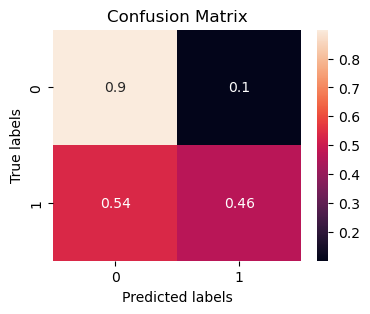

In [59]:

# for thresh in range(21):
for thresh in [.75]:
    # print(thresh/20)
    plt.figure(figsize=(4, 3))
    ax= plt.subplot()
    y_out = np.where(clf.predict_proba(X_test)[:,1] > thresh, 1,0)
    
    #y_test_out = np.where(y_t > 0.5, 1,0)
    cm = confusion_matrix(y_test, y_out)
    #ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    f = sns.heatmap(cm, annot=True,ax=ax)
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    plt.show()
    # break
# print(classification_report(y_test,y_out))

In [60]:
# from xgboost import plot_tree
# import matplotlib.pyplot as plt
# # from sklearn import tree
# from matplotlib.pylab import rcParams
# plot_tree(clf)
# fig = plt.gcf()
# fig.set_size_inches(150, 100)
# fig.savefig('tree.svg')

In [61]:
# thres = .75
# y_pred = 1*(clf.predict_proba(X_test)[:,1]>thres)

# sum(y_pred[y_test==1]==1)/sum(y_test==1) #recall

# sum(y_test[y_pred==1]==1)/ sum(y_pred) #precision

# print(classification_report(y_test, y_pred))

In [62]:
##### end

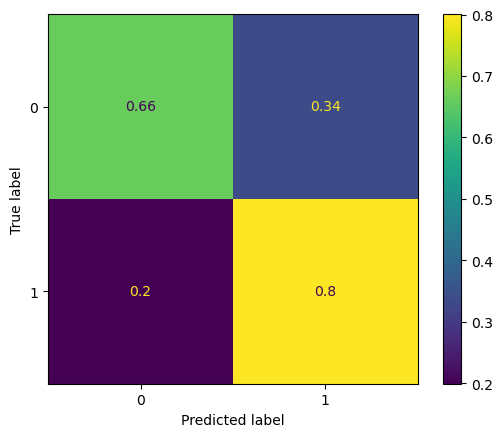

In [63]:
plot_confusion_matrix(clf, X_test, y_test, normalize = 'true')
plt.grid(False)
plt.show()

In [64]:
sum(y_pred == y_test)/len(y_test)

0.5761075703404321

In [65]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": clf.feature_importances_
})
imp_df.sort_values(by="Imp", ascending=False).iloc[:20,:]

,Varname,Imp
43,total_atv,0.202347
14,total_txn_count,0.099553
16,w1_tpv,0.055963
6,total_unique_payers,0.052074
0,w1_unique_payers,0.044096
41,m1_atv,0.040287
40,loc_hash_tpv,0.037142
54,manufacturer,0.033806
15,total_active_vintage,0.028999
53,geohash4,0.028530


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

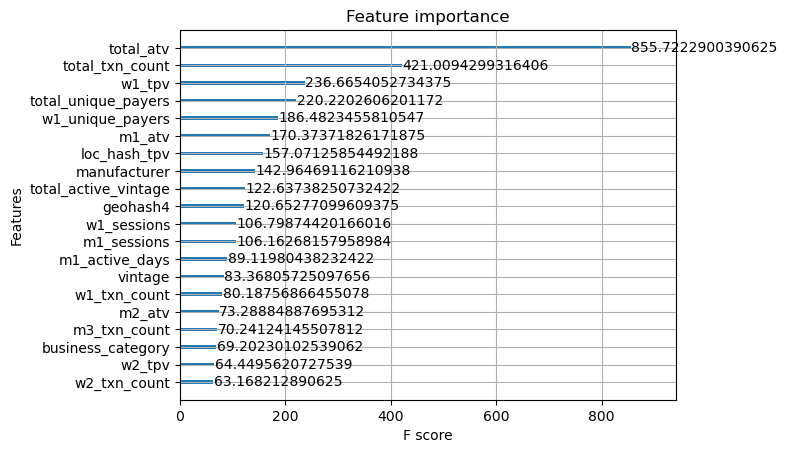

In [66]:
plot_importance(clf, max_num_features =20,importance_type='gain')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

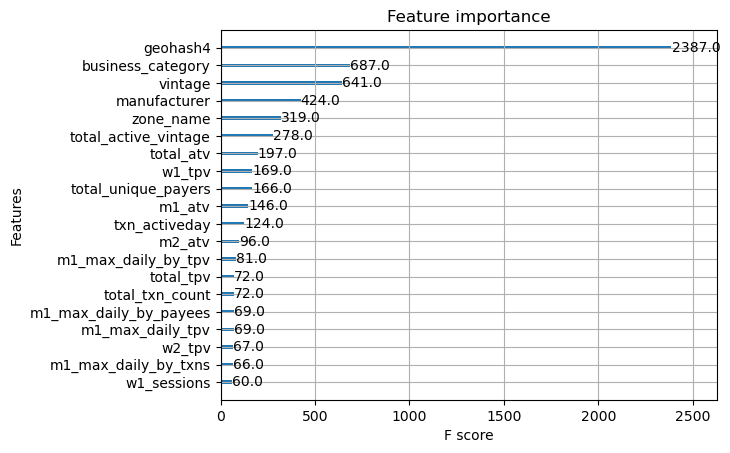

In [67]:
plot_importance(clf, max_num_features =20,importance_type='weight')

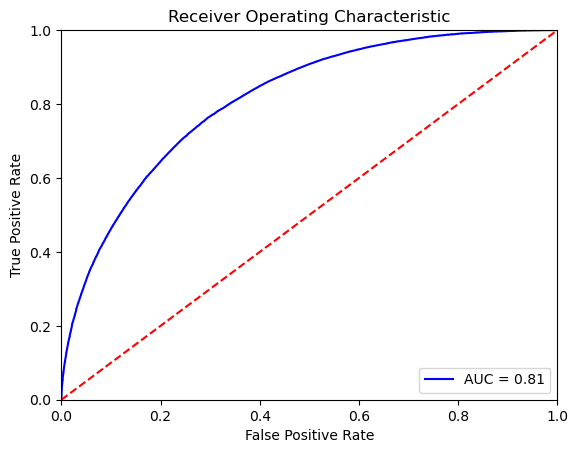

In [68]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

preds = clf.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [69]:
##### EDA

In [70]:
# gain_num =['total_txn_count','w1_txn_count','w1_tpv','w1_unique_payers','m1_active_days','m1_tpv','w1_sessions','total_atv','total_unique_payers','m1_atv',\
# 'total_active_vintage','m1_max_daily_tpv','m2_active_days','m1_sessions']
# gain_cat =['business_category', 'actual_merchant_type','zone_name']

In [71]:
vis_df = pdt_final[list(imp_df['Varname'].unique()) + ['target']]
num_cols = list(vis_df.columns[vis_df.dtypes==np.float]) 
cat_cols = list(vis_df.columns[vis_df.dtypes!=np.float])
num_df = vis_df[num_cols]
cat_df = vis_df[cat_cols]

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = StandardScaler()
scaler = MinMaxScaler()
# num_df = pd.DataFrame(scaler.fit_transform(num_df), index=num_df.index, columns=num_df.columns)
num_df['target'] = pdt_final['target']
num_df['merchant_id'] = pdt_final['merchant_id']
cat_df['target'] = pdt_final['target']
cat_df['merchant_id'] = pdt_final['merchant_id']

In [72]:
def cat_alt(col):
    df = (100*cat_df.groupby(col)["target"].mean()).to_frame().reset_index()
    df['Count of Merchants'] = list(cat_df.groupby(col)["merchant_id"].count())
    alt.themes.enable('fivethirtyeight')
    base = alt.Chart(df).encode(x=alt.X(f'{col}:N',axis=alt.Axis(title="") ))

    bar = base.mark_bar(color = 'lightgrey').encode(y=alt.Y('target:Q',axis=alt.Axis(title="Propensity %")))

    line =  base.mark_line(color='aqua').encode(
        y='Count of Merchants:Q'
    )
    txt_bar = bar.mark_text(align='center',
            baseline='middle',
            dy=-6
    ).encode(
        y=alt.Y('target:Q',axis=alt.Axis(title="",labels=False,ticks=False)),
        text=alt.Text('target:Q',format='1.0d')
    )

    txt_line = line.mark_text(align='center',
            baseline='middle',
            dy=-6, angle = 80, color = 'black'
    ).encode(
        text=alt.Text('Count of Merchants:Q',format='1.0d')
    )

    c = (bar + txt_bar+ line +txt_line).resolve_scale(y='independent').properties(width=650, height = 350, title = f"{col}")
    return c

In [73]:
cat1 = cat_alt('business_category')
cat2 = cat_alt('zone_name')
cat3 = cat_alt('manufacturer')

In [74]:
def num_alt(col):
    bins = [-.01,int(num_df[col].describe()['min']),int(num_df[col].describe()['25%']),int(num_df[col].describe()['50%']),\
           int(num_df[col].describe()['75%']),int(num_df[col].describe()['max'])]

    num_df[col]=pd.cut(x = num_df[col],bins = bins, duplicates = 'drop')
    df = (100*num_df.groupby(col)["target"].mean()).to_frame().reset_index()
    df[col] = df[col].astype('str')
    df['Count of Merchants'] = list(num_df.groupby(col)["merchant_id"].count())
    
    alt.themes.enable('fivethirtyeight')
    base = alt.Chart(df).encode(x=alt.X(f'{col}:O',axis=alt.Axis(title=""), sort = bins ))

    bar = base.mark_bar(color = 'lightgrey').encode(y=alt.Y('target:Q',axis=alt.Axis(title="Propensity %")))

    line =  base.mark_line(color='aqua').encode(
        y='Count of Merchants:Q'
    )
    txt_bar = bar.mark_text(align='center',
            baseline='middle',
            dy=-6
    ).encode(
        y=alt.Y('target:Q',axis=alt.Axis(title="",labels=False,ticks=False)),
        text=alt.Text('target:Q',format='.0f')
    )

    txt_line = line.mark_text(align='center',
            baseline='middle',
            dy=-6, angle = 80, color = 'black'
    ).encode(
        text=alt.Text('Count of Merchants:Q',format='.0f')
    )

    c = (bar + txt_bar+ line +txt_line).resolve_scale(y='independent').properties(width=170, height = 170, title = f"{col}")
    return c

In [75]:
num1 = num_alt('total_txn_count')
num2 = num_alt('m1_tpv')
num3 = num_alt('w1_sessions')
num4 = num_alt('total_atv')
num5 = num_alt('total_unique_payers')
num6 = num_alt('m1_atv')
num7 = num_alt('m1_max_daily_tpv')
num8 = num_alt('m1_active_days')
num8 = num_alt('total_active_vintage')

In [76]:
(num1|num2|num3|num4) & (num5|num6|num7|num8)

alt.VConcatChart(...)

In [77]:
col = geo
cat_df[col] = cat_df[col].astype('str')
top= list(cat_df[col].value_counts()[:50].index)
cat_df = cat_df[cat_df[col].isin(top)]
df = (100*cat_df.groupby(col)["target"].mean()).to_frame().reset_index()
df['Count of Merchants'] = list(cat_df.groupby(col)["merchant_id"].count())
df
alt.themes.enable('fivethirtyeight')
base = alt.Chart(df).encode(x=alt.X(f'{col}:N',axis=alt.Axis(title="") ))

bar = base.mark_bar(color = 'lightgrey').encode(y=alt.Y('target:Q',axis=alt.Axis(title="Propensity %")))

line =  base.mark_line(color='aqua').encode(
    y='Count of Merchants:Q'
)
txt_bar = bar.mark_text(align='center',
        baseline='middle',
        dy=-6
).encode(
    y=alt.Y('target:Q',axis=alt.Axis(title="",labels=False,ticks=False)),
    text=alt.Text('target:Q',format='1.0d')
)

txt_line = line.mark_text(align='center',
        baseline='middle',
        dy=-6, angle = 80, color = 'black'
).encode(
    text=alt.Text('Count of Merchants:Q',format='1.0d')
)

c = (bar + txt_bar+ line +txt_line).resolve_scale(y='independent').properties(width=650, height = 350, title = f"{col}")

In [78]:
cat1.properties(width = 900, height = 250)  & cat2.properties(width = 900, height = 250) & cat3.properties(width = 900, height = 250) & c.properties(width = 900, height = 250)

alt.VConcatChart(...)

In [79]:
 num_alt('vintage')

alt.LayerChart(...)